- author: Johannes L. Fjeldså
- email: johannes.larsen.fjeldså@nmbu.no

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from src.preproces import *

# Import test file

In [2]:
file_handler = Handle_Files()
path_raw_data = '/nird/projects/NS9188K/bjornhs/ACCESS-ESM1-5/'

file_names = file_handler.get_all_netcdf_files_in_dir(path_raw_data)
test_file = file_handler.read_netcdf_to_xr(''.join([path_raw_data, file_names[2]]))
test_file

FileNotFoundError: [WinError 3] Systemet finner ikke angitt bane: '/nird/projects/NS9188K/bjornhs/ACCESS-ESM1-5/'

# Check compatability between mask and file.

In [3]:
def sort_condition(string):
    if 'land' in string:
        return True
    else:
        return False

path_raw_masks = '/nird/projects/NS9188K/bjornhs/ACCESS-ESM1-5/masks/'
file_handler.get_all_filenames_in_dir(path_raw_masks, sort_condition)


['landfrac_ACCESS-ESM1-5.nc']

In [4]:
land_sea_mask = file_handler.read_netcdf_to_xr(''.join([path_raw_masks, 'landfrac_ACCESS-ESM1-5.nc']))
print(land_sea_mask)

preprocesser = Preprocess_Climate_Data()

preprocesser.check_mask_compatability(test_file, 'tas', land_sea_mask)

/nird/home/johannef/.conda/envs/msc_env/lib/python3.12/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/nird/home/johannef/.conda/envs/msc_env/lib/python3.12/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/nird/home/johannef/.conda/envs/msc_env/lib/python3.12/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continu

<xarray.Dataset>
Dimensions:   (time: 1, lon: 192, lat: 145)
Coordinates:
  * time      (time) object 0001-01-01 01:00:00
  * lon       (lon) float64 0.0 1.875 3.75 5.625 ... -7.5 -5.625 -3.75 -1.875
  * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
Data variables:
    landfrac  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    history:      Wed Dec 06 14:14:19 2023: cdo remapcon,grid_ACCESS-ESM1-5.t...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...


ValueError: Mask is not compatible with xr_file
lat compatibility: True
lon compatability: False
time compatability: False

The mask is not compatible, further investigation is needed to discover why lon is not compatible. 

In [5]:
print(f'xr_file lon: \n {test_file.tas.lon}\n')
print(f'mask lon: \n{land_sea_mask.lon}')

xr_file lon: 
 <xarray.DataArray 'lon' (lon: 192)>
array([  0.   ,   1.875,   3.75 ,   5.625,   7.5  ,   9.375,  11.25 ,  13.125,
        15.   ,  16.875,  18.75 ,  20.625,  22.5  ,  24.375,  26.25 ,  28.125,
        30.   ,  31.875,  33.75 ,  35.625,  37.5  ,  39.375,  41.25 ,  43.125,
        45.   ,  46.875,  48.75 ,  50.625,  52.5  ,  54.375,  56.25 ,  58.125,
        60.   ,  61.875,  63.75 ,  65.625,  67.5  ,  69.375,  71.25 ,  73.125,
        75.   ,  76.875,  78.75 ,  80.625,  82.5  ,  84.375,  86.25 ,  88.125,
        90.   ,  91.875,  93.75 ,  95.625,  97.5  ,  99.375, 101.25 , 103.125,
       105.   , 106.875, 108.75 , 110.625, 112.5  , 114.375, 116.25 , 118.125,
       120.   , 121.875, 123.75 , 125.625, 127.5  , 129.375, 131.25 , 133.125,
       135.   , 136.875, 138.75 , 140.625, 142.5  , 144.375, 146.25 , 148.125,
       150.   , 151.875, 153.75 , 155.625, 157.5  , 159.375, 161.25 , 163.125,
       165.   , 166.875, 168.75 , 170.625, 172.5  , 174.375, 176.25 , 178.125,
 

The mask uses negative values as degrees_east > 180 while the test_file uses 360 degree system. The number of lon is equal and thus also the resolution. I will let the mask inherite the lon from the test file and save the altered mask for future useage. 

In [6]:
land_sea_mask['lon'] = test_file.tas.lon

Further we will look into the time compatability. This is needed in order to be able to apply the "ds.where(mask)" to the whole ds and not time slices. 

In [7]:
land_sea_mask_w_ts = land_sea_mask.reindex_like(test_file)

land_sea_mask_w_ts = land_sea_mask_w_ts.assign(
    landfrac=(['lat', 'lon'], 
    np.array(land_sea_mask.isel(time=0)['landfrac'].values))
    )

# rechek compatability, save if it is compatible
if preprocesser.check_mask_compatability(test_file, 'tas', land_sea_mask_w_ts):
    file_handler.save_dataset_to_netcdf(land_sea_mask_w_ts, 
                                        'landfrac_altered_mask_ACCESS-ESM1-5.nc', 
                                        '/nird/home/johannef/Masterthesis_S23 DataFiles/masks')

/nird/home/johannef/.conda/envs/msc_env/lib/python3.12/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


# Apply land_sea mask to test_file

 To visualise the masking we use cartopy plotting. 

In [9]:
path_altered_masks = '/nird/home/johannef/Masterthesis_S23 DataFiles/masks/'
land_sea_mask = file_handler.read_netcdf_to_xr(''.join([path_altered_masks, 'landfrac_altered_mask_ACCESS-ESM1-5.nc']))

In [10]:
def plot_on_globe(data,
                  center_lon=0, center_lat=20,
                  cmap='viridis',
                  title=None, 
                  v_min=None,
                  v_max=None):
    """
    Plot data on a globe.

    Parameters:
    - data (xr.DataArray): The data to be plotted. Horizontal 2D data at a single time step.
    - center_lat (float): The latitude for the center of the plot.
    - center_lon (float): The longitude for the center of the plot.
    - cmap (str or Colormap): The colormap to be used for the plot.
    - title (str): The title of the plot.
    - v_min (float): The minimum value for the colorbar.
    - v_max (float): The maximum value for the colorbar.
    """
    
    p = data.plot(
        subplot_kws=dict(projection=ccrs.Orthographic(center_lon, center_lat), facecolor="gray"),
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=v_min,
        vmax=v_max
    )
    p.axes.set_global()
    p.axes.coastlines()

    if title is None:
        title = "Globe plot"
    plt.title(title)

    plt.show()


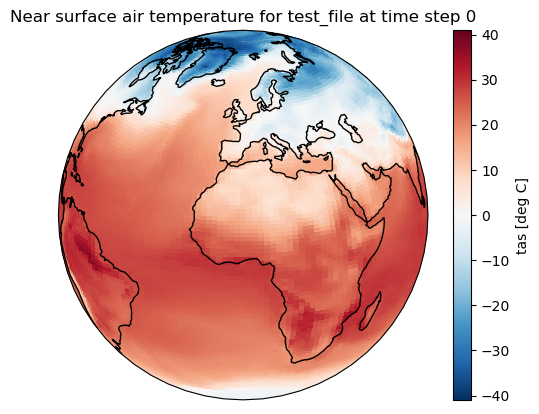

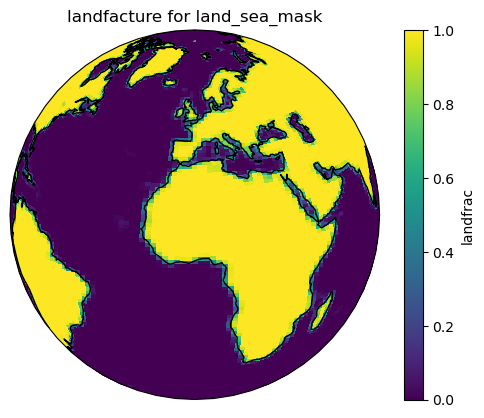

In [11]:
as_celsius = preprocesser.covert_from_K_to_C(test_file.isel(time=0), 'tas')
plot_on_globe(as_celsius.tas, 
              cmap='RdBu_r',
              title='Near surface air temperature for test_file at time step 0')
plot_on_globe(land_sea_mask.isel(time=0).landfrac, title='landfacture for land_sea_mask')

Lets devide the land_sea mask:
- If p > 0.8 -> land
- If 0.2 < p < 0.8 discard (do not want noisy transition regions).
- if 0.2 > p-> ocean

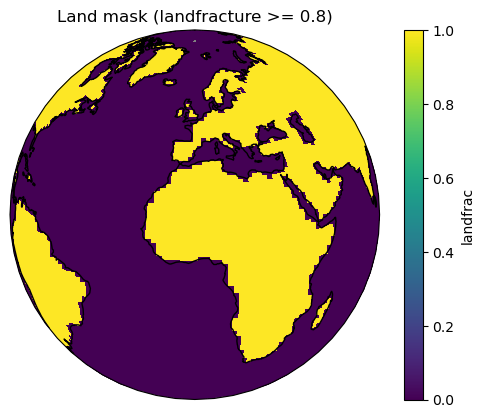

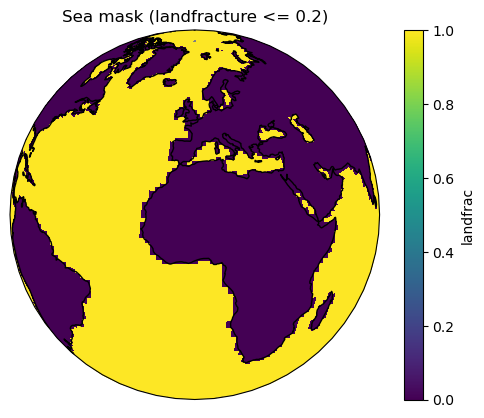

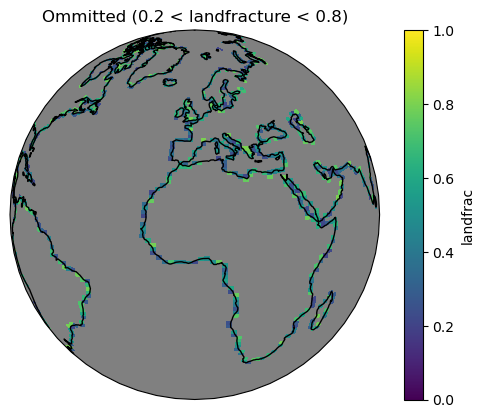

In [12]:
land_mask = land_sea_mask.where(land_sea_mask >= 0.8).notnull()
file_handler.save_dataset_to_netcdf(land_mask, 'land_mask_ACCESS-ESM1-5.nc', '/nird/home/johannef/Masterthesis_S23 DataFiles/masks')
plot_on_globe(land_mask.landfrac, title='Land mask (landfracture >= 0.8)', 
              v_min=0,
              v_max=1)

sea_mask = land_sea_mask.where(land_sea_mask <= 0.2).notnull()
file_handler.save_dataset_to_netcdf(sea_mask, 'sea_mask_ACCESS-ESM1-5.nc', '/nird/home/johannef/Masterthesis_S23 DataFiles/masks')
plot_on_globe(sea_mask.landfrac, title='Sea mask (landfracture <= 0.2)',
              v_min=0,
              v_max=1)

ommitted = land_sea_mask.where(land_sea_mask > 0.2) 
ommitted = ommitted.where(ommitted < 0.8)
plot_on_globe(ommitted.landfrac, title='Ommitted (0.2 < landfracture < 0.8)',
              v_min=0,
              v_max=1)

The masks are ready to be applied to the test file.

In [13]:
land_masked_test_file =  test_file.where(land_mask['landfrac'])

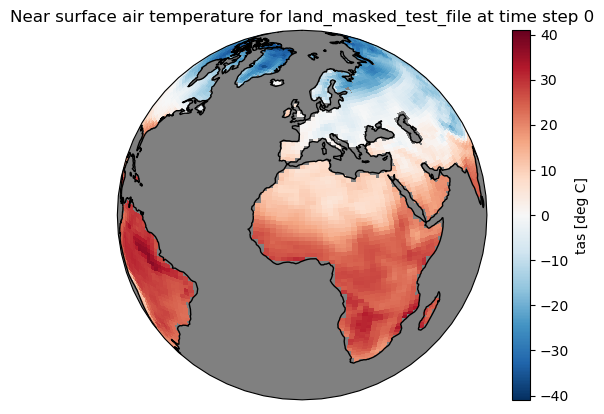

In [16]:
land_as_celsius = preprocesser.covert_from_K_to_C(land_masked_test_file.isel(time=0), 'tas')
plot_on_globe(land_as_celsius.tas, 
              cmap='RdBu_r',
              title='Near surface air temperature for land_masked_test_file at time step 0')

Now we have usable masks for land and sea contrasting. 